In [1]:
import json

import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from tensorflow.keras import activations
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
import keras_tuner as kt
import os
import pandas as pd
import json

In [2]:
X, y = load_breast_cancer(return_X_y=True)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

In [4]:
X_train[1].shape

(30,)

In [5]:
# model_t = keras.Sequential()
# model_t.add(keras.layers.Flatten(input_shape=(30, )))

# model_t.compile(optimizer='rmsprop',
#                 metrics=['accuracy'])


In [6]:
ARCHITECTURES = ['SQU','ASC','DES','SYM','ENC']
def get_units(idx,neurons,architecture,layers=None):
    assert architecture in ARCHITECTURES
    if architecture == 'SQU':
        return neurons
    elif architecture == 'ASC':
        return (2**idx)*neurons
    elif architecture == 'DES':
        return (2**(layers-1-idx))*neurons
    elif architecture=='SYM':
        assert (layers is not None and layers > 2)
        if layers%2==1:
            return neurons*2**(int(layers/2) - abs(int(layers/2)-idx))
        else:
            x = int(layers/2)
            idx  = idx if idx < x else 2*x-idx -1
            return neurons*2**(int(layers/2) - abs(int(layers/2)-idx))
    elif architecture=='ENC':
        # print(layers)
        assert (layers is not None and layers > 2)
        if layers%2==0:
            x = int(layers/2)
            idx  = idx if idx < x else 2*x-idx -1
            return neurons*2**(int(layers/2)-1 -idx)
        else:
            x = int(layers/2)
            idx  = idx if idx < x else 2*x-idx
            return neurons*2**(int(layers/2) -idx)

In [7]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(30, )))
  
  act_type = hp.Choice("activation", ['relu', 'selu'])
  neurons = hp.Choice("neurons", [4,8,16,32])
  arch = hp.Choice("architecture", ['SQU','ASC','DES','SYM','ENC'])
  # print("arch", arch)
  # print("type", type(arch))
  # print("condition:", arch == 'ENC' or arch == 'SYM')
  if arch == 'ENC' or arch == 'SYM':
    layers = hp.Choice("layers", [3,5,7], parent_name='architecture', parent_values=['ENC', 'SYM'])
  else:
    layers = hp.Choice("layers", [3,5,7,1], parent_name='architecture', parent_values=['SQU','ASC','DES'])
  for i in range(layers):
    model.add(
            keras.layers.Dense(
                # Tune number of units separately.
                units=get_units(i, neurons, arch, layers),
                activation=act_type),
            )
    

  # if act_type < 2:
  #   act = {0:'relu', 1:'selu'}[act_type]  
  #   for i in range(hp.Int("num_layers", min_value=1, max_value=5, step=2)):
  #       model.add(
  #           keras.layers.Dense(
  #               # Tune number of units separately.
  #               units=hp.Choice(f"units_{i}", [4, 8, 16]),
  #               activation=act),
  #           )
  # else:
  #   for i in range(hp.Int("num_layers", min_value=1, max_value=5, step=2)):
  #       model.add(
  #           keras.layers.Dense(
  #               # Tune number of units separately.
  #               units=hp.Choice(f"units_{i}", [4, 8, 16])),
  #           )  
  #       model.add(keras.layers.LeakyReLU())

  drop = hp.Choice('dropout_rate', [0.0, 0.5])
  model.add(keras.layers.Dropout(rate=drop))

  # if hp.Boolean('batch_normalization'):
  #   model.add(keras.layers.BatchNormalization())

  
  optimz = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])

  model.compile(optimizer=optimz,
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [151]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=150,
                     factor=3,
                    #  hyperband_iterations=10,
                     overwrite=True,
                     project_name="project2")

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

tuner.search(X_train, y_train, epochs=140, validation_split=0.25)


Trial 254 Complete [00h 00m 09s]
val_accuracy: 0.9473684430122375

Best val_accuracy So Far: 0.9649122953414917
Total elapsed time: 00h 04m 49s
INFO:tensorflow:Oracle triggered exit


In [44]:
m = tuner.get_best_models()

In [45]:
x = tuner.get_best_hyperparameters()
x[0].get_config()['values']

{'activation': 'selu',
 'neurons': 32,
 'architecture': 'ASC',
 'layers': 5,
 'dropout_rate': 0.0,
 'optimizer': 'adam',
 'tuner/epochs': 100,
 'tuner/initial_epoch': 34,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '1de1c6584693255a012ad87d40cf8f7a'}

In [5]:
trial_folder = "project2/"
files = []
for i in os.listdir(trial_folder):
    if os.path.isdir(os.path.join(trial_folder, i)):
        files.append(i)

files = [os.path.join(trial_folder, f) for f in files]
# files

In [6]:
df = pd.DataFrame(columns=['Dropout [0.0, 0.5]', '"LAYERS": [3.0, 5.0, 7.0, 1.0]',
                           '"NEURONS": [4.0, 8.0, 16.0, 32.0]', 'ReLU',	'SeLU',
                           'ASC', 'ENC', 'EXDES', 'SQU', 'SYM', 'Acc'])

lay = [1, 3, 5, 7]
neu = [4, 8, 16, 32]
for _, fi in enumerate(files):
    xi = json.load(open(fi+"/trial.json", 'r'))
    row = []
    val = xi['hyperparameters']['values']
    row.append(val['dropout_rate'])
    row.append(lay.index(val['layers'])/(len(lay)-1))
    row.append(neu.index(val['neurons'])/(len(neu)-1))
    row.append(1 if val['activation'] == 'relu' else 0)
    row.append(1 if val['activation'] == 'selu' else 0)
    row.append(1 if val['architecture'] == 'ASC' else 0)
    row.append(1 if val['architecture'] == 'ENC' else 0)
    row.append(1 if val['architecture'] == 'DES' else 0)
    row.append(1 if val['architecture'] == 'SQU' else 0)
    row.append(1 if val['architecture'] == 'SYM' else 0)
    row.append(xi['score'])
    df.loc[len(df)] = row
# df

In [23]:
df.sort_values(by=['Acc'], ascending=False)

,"Dropout [0.0, 0.5]","""LAYERS"": [3.0, 5.0, 7.0, 1.0]","""NEURONS"": [4.0, 8.0, 16.0, 32.0]",ReLU,SeLU,ASC,ENC,EXDES,SQU,SYM,Acc
45,0.0,0.666667,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.964912
173,0.0,0.666667,1.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.956140
183,0.0,0.666667,1.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.956140
150,0.5,1.000000,0.333333,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.956140
242,0.5,1.000000,0.333333,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.956140
...,...,...,...,...,...,...,...,...,...,...,...
38,0.0,0.000000,0.333333,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000
122,0.5,0.333333,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000
120,0.5,0.333333,1.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000
33,0.5,0.000000,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000


In [8]:
df2 = df.sort_values(by=['ReLU', 'Dropout [0.0, 0.5]', '"LAYERS": [3.0, 5.0, 7.0, 1.0]', '"NEURONS": [4.0, 8.0, 16.0, 32.0]'],
                     ascending=(False, True, False, True))
df2 = df2.drop(['Acc'], axis=1)

In [9]:
og = pd.read_csv("breast-cancer.csv")
dic = {0.0: 0.0, 0.142857143: 0.333333333, 0.428571429: 0.666666667, 1.0: 1.0}
for i, row in og.iterrows():
    og.at[i, '"NEURONS": [4.0, 8.0, 16.0, 32.0]'] = dic[og.at[i, '"NEURONS": [4.0, 8.0, 16.0, 32.0]']]

In [10]:
og2 = og.drop(['Acc'], axis=1)

In [11]:
og2

,"Dropout [0.0, 0.5]","""LAYERS"": [3.0, 5.0, 7.0, 1.0]","""NEURONS"": [4.0, 8.0, 16.0, 32.0]",ReLU,SeLU,ASC,ENC,EXDES,SQU,SYM
0,0,0.333333,0.000000,1,0,1,0,0,0,0
1,0,0.333333,0.333333,1,0,1,0,0,0,0
2,0,0.333333,0.666667,1,0,1,0,0,0,0
3,0,0.333333,1.000000,1,0,1,0,0,0,0
4,0,0.666667,0.000000,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
251,1,0.666667,1.000000,0,1,0,0,0,0,1
252,1,1.000000,0.000000,0,1,0,0,0,0,1
253,1,1.000000,0.333333,0,1,0,0,0,0,1
254,1,1.000000,0.666667,0,1,0,0,0,0,1


In [12]:
df2

,"Dropout [0.0, 0.5]","""LAYERS"": [3.0, 5.0, 7.0, 1.0]","""NEURONS"": [4.0, 8.0, 16.0, 32.0]",ReLU,SeLU,ASC,ENC,EXDES,SQU,SYM
48,0.0,1.0,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0
124,0.0,1.0,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0
134,0.0,1.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0
136,0.0,1.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0
142,0.0,1.0,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
101,0.5,0.0,0.333333,0.0,1.0,0.0,0.0,1.0,0.0,0.0
68,0.5,0.0,0.666667,0.0,1.0,0.0,0.0,1.0,0.0,0.0
145,0.5,0.0,0.666667,0.0,1.0,1.0,0.0,0.0,0.0,0.0
199,0.5,0.0,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [13]:
d = df2.merge(og2, how = 'inner' ,indicator=True)
d

C:\Users\asmit\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\reshape\merge.py:1204: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


,"Dropout [0.0, 0.5]","""LAYERS"": [3.0, 5.0, 7.0, 1.0]","""NEURONS"": [4.0, 8.0, 16.0, 32.0]",ReLU,SeLU,ASC,ENC,EXDES,SQU,SYM,_merge
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,both
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,both
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,both
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,both
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,both
5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,both
6,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,both
7,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,both
8,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,both
9,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,both


In [14]:
acc_my = df['Acc'].to_list()
acc_og = og['Acc'].to_list()

In [15]:
y = [i for i in range(256)]
y2 = [i for i in range(254)]

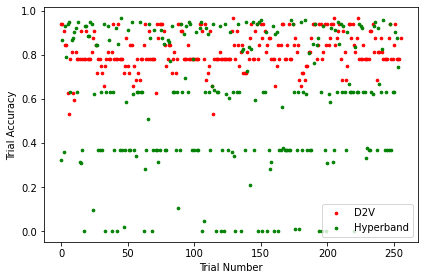

In [21]:
S = 7
plt.xlabel("Trial Number")
plt.ylabel("Trial Accuracy")
plt.scatter(y, acc_og, c='red', s=S, label="D2V")
plt.scatter(y2, acc_my, c='green', s=S, label="Hyperband")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("hyperband_cmp.png", dpi=300)

254

In [142]:
df3 = df2.drop_duplicates()

In [141]:
df3

,"Dropout [0.0, 0.5]","""LAYERS"": [3.0, 5.0, 7.0, 1.0]","""NEURONS"": [4.0, 8.0, 16.0, 32.0]",ReLU,SeLU,ASC,ENC,EXDES,SQU,SYM
0,0,0.333333,0.000000,1,0,1,0,0,0,0
1,0,0.333333,0.333333,1,0,1,0,0,0,0
2,0,0.333333,0.666667,1,0,1,0,0,0,0
3,0,0.333333,1.000000,1,0,1,0,0,0,0
4,0,0.666667,0.000000,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
251,1,0.666667,1.000000,0,1,0,0,0,0,1
252,1,1.000000,0.000000,0,1,0,0,0,0,1
253,1,1.000000,0.333333,0,1,0,0,0,0,1
254,1,1.000000,0.666667,0,1,0,0,0,0,1


In [ ]:
x = tuner.get_best_hyperparameters(num_trials=1000)[0]
model = tuner.hypermodel.build(x)
history = model.fit(X_train, y_train, epochs=125, validation_split=0.25)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [165]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [166]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=500, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/500
12/12 [==============================] - 1s 13ms/step - loss: 11.9943 - accuracy: 0.1374 - val_loss: 2.8778 - val_accuracy: 0.3407
Epoch 2/500
12/12 [==============================] - 0s 4ms/step - loss: 2.2442 - accuracy: 0.3022 - val_loss: 2.0777 - val_accuracy: 0.3407
Epoch 3/500
12/12 [==============================] - 0s 4ms/step - loss: 1.7173 - accuracy: 0.3297 - val_loss: 2.8547 - val_accuracy: 0.3407
Epoch 4/500
12/12 [==============================] - 0s 4ms/step - loss: 1.8236 - accuracy: 0.3269 - val_loss: 3.1730 - val_accuracy: 0.3407
Epoch 5/500
12/12 [==============================] - 0s 5ms/step - loss: 1.7537 - accuracy: 0.3352 - val_loss: 2.1596 - val_accuracy: 0.0330
Epoch 6/500
12/12 [==============================] - 0s 4ms/step - loss: 1.6648 - accuracy: 0.3352 - val_

In [167]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.25)

Epoch 1/337
11/11 [==============================] - 0s 11ms/step - loss: 47.7321 - accuracy: 0.4194 - val_loss: 28.4385 - val_accuracy: 0.5965
Epoch 2/337
11/11 [==============================] - 0s 5ms/step - loss: 22.3927 - accuracy: 0.4516 - val_loss: 14.5272 - val_accuracy: 0.0351
Epoch 3/337
11/11 [==============================] - 0s 4ms/step - loss: 9.4512 - accuracy: 0.2581 - val_loss: 2.4202 - val_accuracy: 0.0789
Epoch 4/337
11/11 [==============================] - 0s 4ms/step - loss: 2.2780 - accuracy: 0.3314 - val_loss: 1.2026 - val_accuracy: 0.2719
Epoch 5/337
11/11 [==============================] - 0s 4ms/step - loss: 1.8215 - accuracy: 0.4135 - val_loss: 0.9762 - val_accuracy: 0.5000
Epoch 6/337
11/11 [==============================] - 0s 4ms/step - loss: 1.6627 - accuracy: 0.4604 

In [168]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

4/4 [==============================] - 0s 2ms/step - loss: 0.1893 - accuracy: 0.9211
[test loss, test accuracy]: [0.18931527435779572, 0.9210526347160339]


In [ ]:

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \nNumber of layes: {best_hps.get('layers')} \nThe optimal arch is {best_hps.get('architecture')}.
""")


The hyperparameter search is complete. 
Number of layes: 7 
The optimal arch is SQU.



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=500, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/500
12/12 [==============================] - 1s 23ms/step - loss: 151.2558 - accuracy: 0.0000e+00 - val_loss: 71.2594 - val_accuracy: 0.0000e+00
Epoch 2/500
12/12 [==============================] - 0s 6ms/step - loss: 25.8518 - accuracy: 0.2143 - val_loss: 3.2633 - val_accuracy: 0.3516
Epoch 3/500
12/12 [==============================] - 0s 5ms/step - loss: 1.8447 - accuracy: 0.7088 - val_loss: 2.5901 - val_accuracy: 0.3736
Epoch 4/500
12/12 [==============================] - 0s 5ms/step - loss: 1.1836 - accuracy: 0.7088 - val_loss: 0.5258 - val_accuracy: 0.8681
Epoch 5/500
12/12 [==============================] - 0s 8ms/step - loss: 0.5039 - accuracy: 0.8077 - val_loss: 0.5664 - val_accuracy: 0.8571
Epoch 6/500
12/12 [==============================] - 0s 6ms/step - loss: 0.3955 - accuracy: 0.8874 - val_loss: 0.1634 - val_accuracy: 0.9451
Epoch 7/500
12/12 [==============================] - 0s 5ms/step - loss: 0.2639 - accuracy: 0.9093 - val_loss: 0.2401 - val_accuracy: 0.8791


In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/353
12/12 [==============================] - 1s 19ms/step - loss: 132.6167 - accuracy: 0.0000e+00 - val_loss: 96.1251 - val_accuracy: 0.0000e+00
Epoch 2/353
12/12 [==============================] - 0s 7ms/step - loss: 72.3915 - accuracy: 0.0000e+00 - val_loss: 40.7764 - val_accuracy: 0.0000e+00
Epoch 3/353
12/12 [==============================] - 0s 5ms/step - loss: 22.0073 - accuracy: 0.0000e+00 - val_loss: 2.8043 - val_accuracy: 0.0110
Epoch 4/353
12/12 [==============================] - 0s 5ms/step - loss: 3.2432 - accuracy: 0.2555 - val_loss: 2.0644 - val_accuracy: 0.0769
Epoch 5/353
12/12 [==============================] - 0s 6ms/step - loss: 1.6678 - accuracy: 0.2830 - val_loss: 1.0399 - val_accuracy: 0.3407
Epoch 6/353
12/12 [==============================] - 0s 7ms/step - loss: 0.6662 - accuracy: 0.6593 - val_loss: 0.4803 - val_accuracy: 0.7802
Epoch 7/353
12/12 [==============================] - 0s 7ms/step - loss: 0.4506 - accuracy: 0.8324 - val_loss: 0.3739 - val_acc

In [4]:
plot_model(hypermodel, show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [ ]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

4/4 [==============================] - 0s 3ms/step - loss: 0.1570 - accuracy: 0.9561
[test loss, test accuracy]: [0.15704385936260223, 0.9561403393745422]


In [3]:
hypermodel.save("model")

INFO:tensorflow:Assets written to: model\assets


In [174]:
type(hypermodel)

keras.engine.sequential.Sequential

In [2]:
hypermodel = keras.models.load_model("model")